In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from datetime import timedelta
import seaborn as sns
import mplfinance as mpf

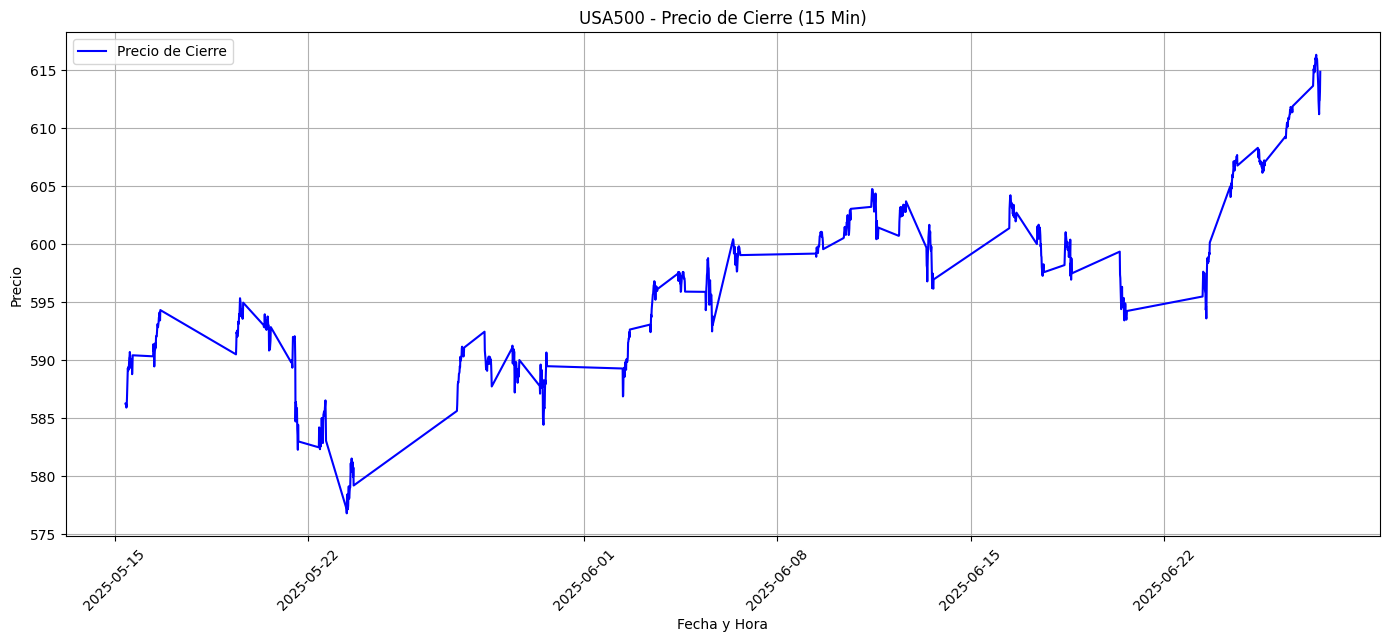

In [2]:
# Ruta del archivo Excel
file_path = r"C:\Users\gblan\OneDrive\Escritorio\Programacion\Jupyter\data\spy_15m_30dias.xlsx"

# Cargar archivo
df = pd.read_excel(file_path)

# Convertir columna de fecha y hora a datetime (asumiendo está en una sola columna llamada 'DateTime')
# Puedes cambiar 'DateTime' por el nombre real de tu columna si es distinto
df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=True)

# Convertir columnas 'Date' y 'Time' en una sola columna datetime
# df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str), format='%Y%m%d %H:%M:%S')

# Ordenar por fecha y hora
df = df.sort_values('Datetime')

# Graficar el precio de cierre
plt.figure(figsize=(14, 6))
plt.plot(df['Datetime'], df['Close'], label='Precio de Cierre', color='blue')
plt.title('USA500 - Precio de Cierre (15 Min)')
plt.xlabel('Fecha y Hora')
plt.ylabel('Precio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

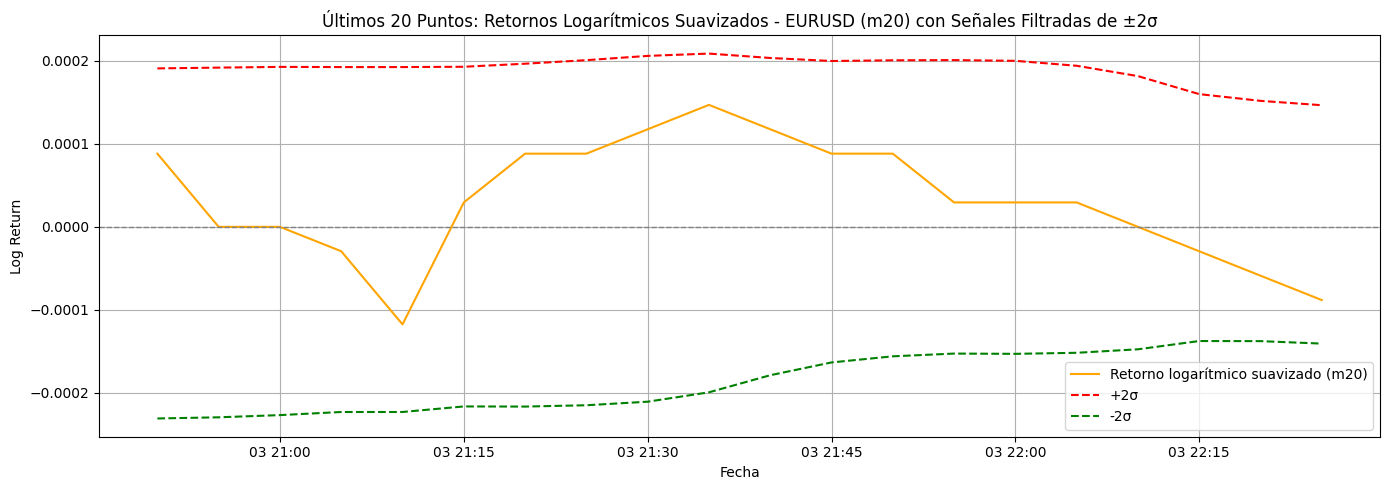

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Descargar datos de EUR/USD ---
ticker = yf.Ticker("EURUSD=X")
df = ticker.history(interval="5m", period="5d")
df.index = df.index.tz_localize(None)

# --- Calcular retornos logarítmicos ---
df['log_ret'] = (df['Close'] / df['Close'].shift(1)).apply(lambda x: np.log(x))

# --- Suavizado de la serie de retornos con ventana de 20m ---
df['log_ret_smooth_20m'] = df['log_ret'].rolling(window=4).mean() # 20m / 5m = 4 periods

# --- Calcular media y desviación sobre log_ret_smooth_20m ---
media_20m = df['log_ret_smooth_20m'].rolling(window=50).mean()
std_20m = df['log_ret_smooth_20m'].rolling(window=50).std()

df['upper_20m'] = media_20m + 2 * std_20m
df['lower_20m'] = media_20m - 2 * std_20m

# --- Confirmación por 2 velas consecutivas (20m) ---
df['above_upper_20m'] = df['log_ret_smooth_20m'] > df['upper_20m']
df['below_lower_20m'] = df['log_ret_smooth_20m'] < df['lower_20m']

# --- Umbral mínimo de magnitud (20m) ---
threshold = 0.0008
df['evento_20m'] = None
df.loc[(df['above_upper_20m'].rolling(2).sum() == 2) &
       (df['log_ret_smooth_20m'] > threshold), 'evento_20m'] = 'Reversión (+2σ)'
df.loc[(df['below_lower_20m'].rolling(2).sum() == 2) &
       (df['log_ret_smooth_20m'] < -threshold), 'evento_20m'] = 'Reversión (-2σ)'

# --- GRAFICAR (m20) - Solo los últimos 20 puntos ---
plt.figure(figsize=(14, 5))
# Slice the DataFrame to get only the last 20 rows for plotting
df_last_20_m20 = df.tail(20)

plt.plot(df_last_20_m20['log_ret_smooth_20m'], label='Retorno logarítmico suavizado (m20)', color='orange')
plt.plot(df_last_20_m20['upper_20m'], linestyle='--', color='red', label='+2σ')
plt.plot(df_last_20_m20['lower_20m'], linestyle='--', color='green', label='-2σ')
plt.axhline(0, linestyle='--', color='gray', linewidth=1)

# Marcar puntos de evento en los últimos 20 puntos
eventos_last_20_m20 = df_last_20_m20.dropna(subset=['evento_20m'])
plt.scatter(eventos_last_20_m20.index, eventos_last_20_m20['log_ret_smooth_20m'], color='purple', marker='o', s=50, zorder=5)

plt.title("Últimos 20 Puntos: Retornos Logarítmicos Suavizados - EURUSD (m20) con Señales Filtradas de ±2σ")
plt.xlabel("Fecha")
plt.ylabel("Log Return")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

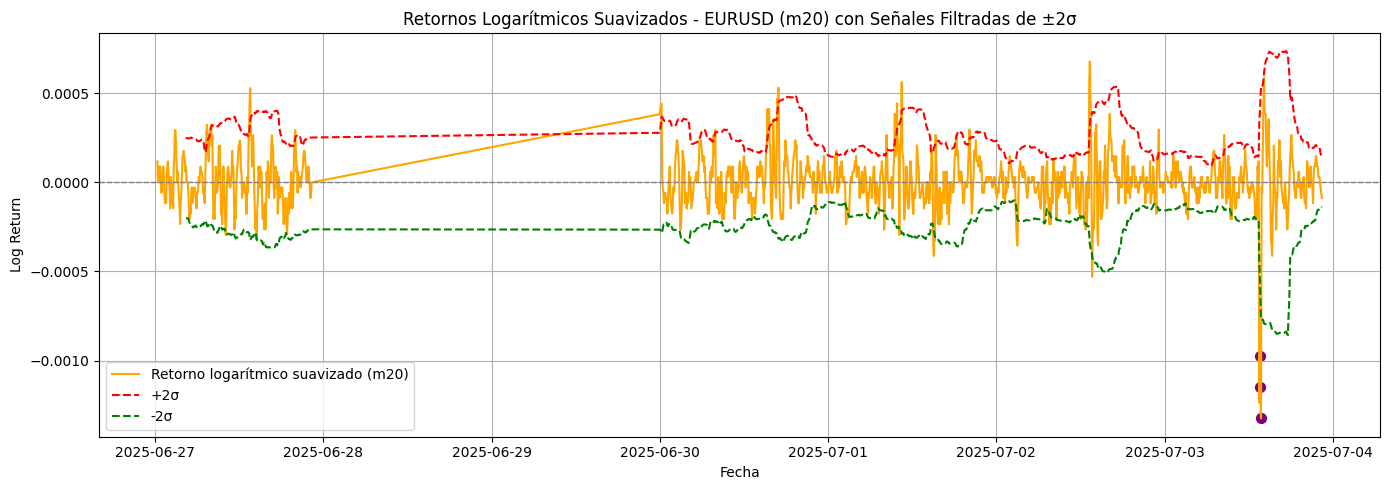

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np # Make sure numpy is imported
import matplotlib.pyplot as plt

# --- Descargar datos de EUR/USD ---
ticker = yf.Ticker("EURUSD=X")
df = ticker.history(interval="5m", period="5d")
df.index = df.index.tz_localize(None)

# --- Calcular retornos logarítmicos ---
df['log_ret'] = (df['Close'] / df['Close'].shift(1)).apply(lambda x: np.log(x))

# --- Suavizado de la serie de retornos con ventana de 20m ---
# Since the original data is 5m intervals, a 20m window means 20/5 = 4 periods
df['log_ret_smooth_20m'] = df['log_ret'].rolling(window=4).mean()

# --- Calcular media y desviación sobre log_ret_smooth_20m ---
media_20m = df['log_ret_smooth_20m'].rolling(window=50).mean()
std_20m = df['log_ret_smooth_20m'].rolling(window=50).std()

df['upper_20m'] = media_20m + 2 * std_20m
df['lower_20m'] = media_20m - 2 * std_20m

# --- Confirmación por 2 velas consecutivas ---
df['above_upper_20m'] = df['log_ret_smooth_20m'] > df['upper_20m']
df['below_lower_20m'] = df['log_ret_smooth_20m'] < df['lower_20m']

# --- Umbral mínimo de magnitud ---
threshold = 0.0008
df['evento_20m'] = None
df.loc[(df['above_upper_20m'].rolling(2).sum() == 2) &
       (df['log_ret_smooth_20m'] > threshold), 'evento_20m'] = 'Reversión (+2σ)'
df.loc[(df['below_lower_20m'].rolling(2).sum() == 2) &
       (df['log_ret_smooth_20m'] < -threshold), 'evento_20m'] = 'Reversión (-2σ)'

# --- GRAFICAR (ventana de 20m) ---
plt.figure(figsize=(14, 5))
plt.plot(df['log_ret_smooth_20m'], label='Retorno logarítmico suavizado (m20)', color='orange')
plt.plot(df['upper_20m'], linestyle='--', color='red', label='+2σ')
plt.plot(df['lower_20m'], linestyle='--', color='green', label='-2σ')
plt.axhline(0, linestyle='--', color='gray', linewidth=1)

# Marcar puntos de evento
eventos_20m = df.dropna(subset=['evento_20m'])
plt.scatter(eventos_20m.index, eventos_20m['log_ret_smooth_20m'], color='purple', marker='o', s=50)

plt.title("Retornos Logarítmicos Suavizados - EURUSD (m20) con Señales Filtradas de ±2σ")
plt.xlabel("Fecha")
plt.ylabel("Log Return")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [5]:
# --- OBTENER EL ÚLTIMO VALOR DISPONIBLE ---
ultimo_log_ret = df['log_ret'].iloc[-1]
ultimo_upper = df['upper'].iloc[-1]
ultimo_lower = df['lower'].iloc[-1]

# --- EVALUAR SITUACIÓN ACTUAL ---
if ultimo_log_ret > ultimo_upper:
    print("⚠️ Rendimiento actual está en +2 desviaciones estándar (posible reversión a la media).")
elif ultimo_log_ret < ultimo_lower:
    print("⚠️ Rendimiento actual está en -2 desviaciones estándar (posible reversión a la media).")
else:
    print("✅ Rendimiento actual dentro del rango normal (dentro de ±2 desviaciones estándar).")

KeyError: 'upper'

In [ ]:
# --- CONFIGURACIÓN ---
window = 20
initial_balance = 10_000  # Balance fijo para cálculo de PnL
risk_unit = 0.01 * initial_balance  # 1% de riesgo fijo ($100 por operación)

# --- ESTADÍSTICAS ---
df['mean'] = df['log_ret'].rolling(window).mean()
df['std'] = df['log_ret'].rolling(window).std()
df['z_score'] = (df['log_ret'] - df['mean']) / df['std']

# --- INICIALIZACIÓN ---
in_position = False
position_type = None
entry_index = None

returns = []  # Ganancias/pérdidas absolutas (no log)
r_multiples = []

# --- BACKTEST ---
for i in range(window + 1, len(df)):
    z = df['z_score'].iloc[i]

    if not in_position:
        if z <= -2:
            in_position = True
            position_type = 'long'
            entry_index = i
        elif z >= 2:
            in_position = True
            position_type = 'short'
            entry_index = i

    elif in_position:
        z_entry = df['z_score'].iloc[entry_index]
        z_slice = df['z_score'].iloc[entry_index + 1 : i + 1]
        logret_slice = df['log_ret'].iloc[entry_index + 1 : i + 1]

        if position_type == 'long':
            if z >= 0:  # TP
                actual_return = logret_slice.sum()
                r_multiple = actual_return / abs(1 * df['std'].iloc[entry_index])
                returns.append(r_multiple * risk_unit)
                r_multiples.append(r_multiple)
                in_position = False

            elif (z_slice > (z_entry + 1)).any():  # SL
                returns.append(-risk_unit)
                r_multiples.append(-1)
                in_position = False

        elif position_type == 'short':
            if z <= 0:  # TP
                actual_return = logret_slice.sum()
                r_multiple = -actual_return / abs(1 * df['std'].iloc[entry_index])
                returns.append(r_multiple * risk_unit)
                r_multiples.append(r_multiple)
                in_position = False

            elif (z_slice < (z_entry - 1)).any():  # SL
                returns.append(-risk_unit)
                r_multiples.append(-1)
                in_position = False

# --- RESULTADOS ---
returns = pd.Series(returns)
equity_curve = initial_balance + returns.cumsum()

# --- GRAFICAR ---
plt.figure(figsize=(14, 6))
plt.plot(equity_curve, label='Estrategia con SL 1σ y TP en media (sin interés compuesto)', color='teal')
plt.title('Backtest - Reversión a la Media (Balance Fijo, sin Interés Compuesto)')
plt.xlabel('Operación #')
plt.ylabel('Balance ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- ESTADÍSTICAS ---
print(f"Balance final: ${equity_curve.iloc[-1]:.2f}")
print(f"Ganancia total: ${returns.sum():.2f}")
print(f"Número de operaciones: {len(returns)}")
print(f"% operaciones ganadoras: {(returns > 0).mean() * 100:.2f}%")
print(f"Ratio promedio R: {np.mean([r for r in r_multiples if r > 0]):.2f}")
print(f"Drawdown máximo: ${np.max(np.maximum.accumulate(equity_curve) - equity_curve):.2f}")
